In [117]:
import pandas as pd 
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import sys
sys.path.append('../')
import commons as cm
from data_curation import Normalization
from pandasql import sqldf
import pupillometry_commons as cp

nm=Normalization()

session_location = Path(r"P:\Proyectos\2020\PY200016 - XSCAPE\Trabajo\00 XPERIMENTS\01 EXPERIMENTS_Santiago\01 ONGOING\Exp_Stgo_0001\SESSIONS")
sessions=[]
df_list=[]
windows_s=3
seconds_norm=0.05
with open('session.txt','r') as f:
    for session in f:
            sessions.append(session.replace('\n',''))
f.close()

session_loc_list=[session_location.joinpath(session,'01 Processing_data','pupil_labs') for session in sessions ]
session_raw_list=[session_location.joinpath(session, '00 Raw_data','pupil_labs') for session in sessions ]

image_loc_list=[session_location.joinpath(session,'images_order') for session in sessions ]

for subject, recording_location in zip(sessions,session_loc_list):
    recording_folder=[record for record in os.listdir(recording_location)  if '00' in record]
    #Load data in folders
    if len(recording_folder)>1:
        ValueError('Ambiguty in folder of experiment')
    recording_location=recording_location.joinpath(recording_folder[0],'exports')
    recording_location_raw=recording_location.joinpath(recording_folder[0],'exports')
    export_folder=[record for record in os.listdir(recording_location)  if '00' in record]
    if len(export_folder)>1:
        ValueError('Ambiguty in folder of exports')
    recording_location=recording_location.joinpath(export_folder[0])

    gaze_surf_csv=[record for record in os.listdir(recording_location.joinpath('surfaces'))  if 'gaze_positions' in record][0]

    print(f'Analixing session: {subject}')

    exported_pupil_csv = recording_location.joinpath('pupil_positions.csv')
    pupil_pd_frame = pd.read_csv(exported_pupil_csv)
    exported_gaze_csv = os.path.join(recording_location,'gaze_positions.csv')
    gaze_pd_frame = pd.read_csv(exported_gaze_csv)
    annotations_csv = os.path.join(recording_location,'annotations.csv')
    annotations_pd = pd.read_csv(annotations_csv)
    surface_gaze_csv = os.path.join(recording_location, 'surfaces',gaze_surf_csv)
    surfaces_pd_frame = pd.read_csv(surface_gaze_csv)

Analixing session: ES0001_S006_PC_EM


In [21]:
recording_location=Path('P:/Proyectos/2020/PY200016 - XSCAPE/Trabajo/00 XPERIMENTS/01 EXPERIMENTS_Santiago/01 ONGOING/Exp_Stgo_0001/SESSIONS/ES0001_S006_PC_EM/01 Processing_data/pupil_labs/007')

In [118]:
from pyplr import graphing
from pyplr import preproc
from pyplr import utils

samples=pupil_pd_frame
# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter_3d',
            'diameter']

detector_3d_data = pupil_pd_frame[pupil_pd_frame.method == 'pye3d 0.3.0 real-time']

pupil_left_eye_interpolated=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1)]
samples=pupil_left_eye_interpolated
pupil_pd_frame.head()

,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_y,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle
0,15954.352296,21612,0,1.0,0.468715,0.304186,24.597393,2d c++,89.993271,133.596298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15954.352296,21612,0,1.0,0.468719,0.304174,24.599304,pye3d 0.3.0 real-time,89.993973,133.598683,...,0.501940,-0.539044,1.417663,1.044956,-2.468711,139.766627,95.583621,158.377541,158.377541,0.0
2,15954.352308,21612,1,1.0,0.444001,0.784299,26.855793,2d c++,85.248177,41.414566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15954.352308,21612,1,1.0,0.444001,0.784307,26.856370,pye3d 0.3.0 real-time,85.248126,41.413125,...,-0.448292,-0.839750,1.311242,2.035650,-1.920610,113.888680,85.928632,173.957009,173.957009,0.0
4,15954.360234,21613,0,1.0,0.468566,0.303868,24.436296,2d c++,89.964767,133.657379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
from pyplr import graphing
from pyplr import preproc
from pyplr import utils


# Load pupil data
SAMPLE_RATE = 123.93247405412919

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject='Example')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);


In [112]:
samples['diameter_3d'].plot()

<AxesSubplot:>

In [85]:
# samples.shape[0]
pupil_pd_frame.shape[0]

309044

In [51]:
# Pupil Labs recording directory
rec_dir = 'P:/Proyectos/2020/PY200016 - XSCAPE/Trabajo/00 XPERIMENTS/01 EXPERIMENTS_Santiago/01 ONGOING/Exp_Stgo_0001/SESSIONS/ES0001_S006_PC_EM/01 Processing_data/pupil_labs/007'
utils.print_file_structure(rec_dir)

007/
    annotation.pldata
    annotation_player.pldata
    annotation_player_timestamps.npy
    annotation_timestamps.npy
    eye0.intrinsics
    eye0.mp4
    eye0_lookup.npy
    eye0_timestamps.npy
    eye1.intrinsics
    eye1.mp4
    eye1_lookup.npy
    eye1_timestamps.npy
    gaze.pldata
    gaze_timestamps.npy
    info.player.json
    notify.pldata
    notify_timestamps.npy
    pupil.pldata
    pupil_timestamps.npy
    square_marker_cache
    surface_definitions_v01
    user_info.csv
    world.intrinsics
    world.mp4
    world_lookup.npy
    world_timestamps.npy
    exports/
        000/
            annotations.csv
            export_info.csv
            fixation_report.csv
            fixations.csv
            gaze_positions.csv
            pupil_gaze_positions_info.txt
            pupil_positions.csv
            pyplr_analysis/
            surfaces/
                fixations_on_surface_Surface 1.csv
                gaze_positions_on_surface_Surface 1.csv
                heatmap

In [52]:
# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter_3d',
            'diameter']

# Get a handle on a subject
s = utils.new_subject(
    rec_dir, export='000', out_dir_nm='pyplr_analysis')

# Load pupil data
samples = utils.load_pupil(
    s['data_dir'], eye_id='best',method='pye3d 0.3.0 real-time', cols=use_cols)
samples

************************************************************
*************************** 007 ****************************
************************************************************


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

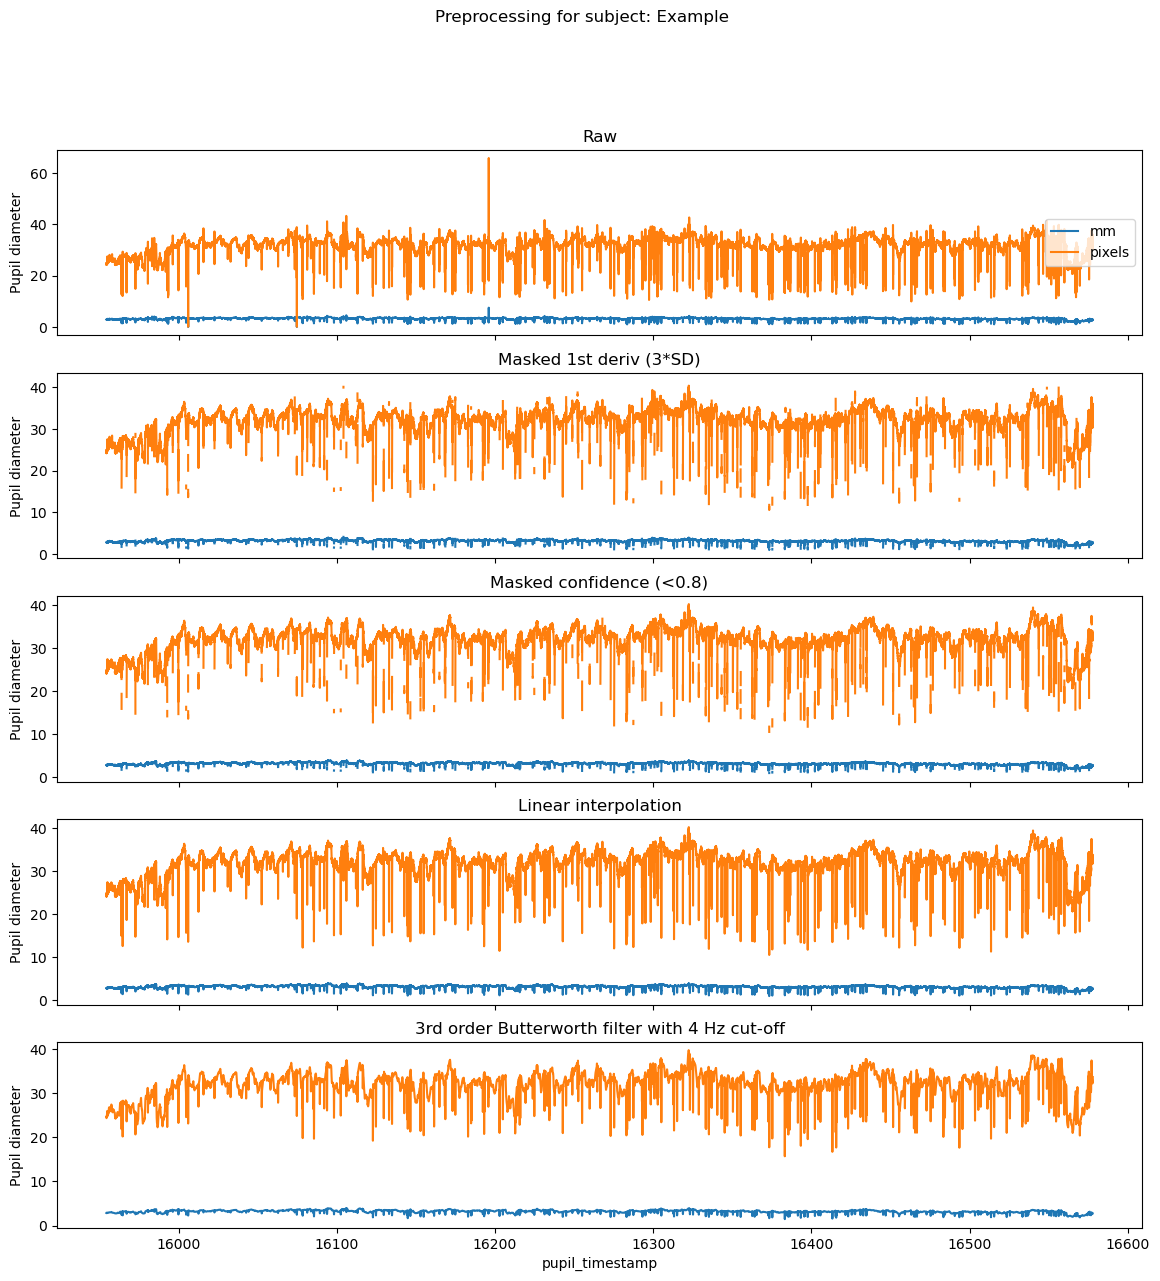

In [32]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject='Example')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);


In [33]:
events = utils.load_annotations(s['data_dir'])
events

Loaded 163 events


,index,label,duration
timestamp,,,
16002.012757,24426,blank_0,NaN
16004.001021,24544,drift_point_0,NaN
16006.001134,24664,Asset0012.tif,NaN
16012.031073,25023,blank_1,NaN
16014.018222,25141,drift_point_1,NaN
...,...,...,...
16526.885912,55747,Asset0015.tif,NaN
16532.916480,56107,blank_53,NaN
16534.903960,56225,drift_point_53,NaN


In [35]:
# Number of samples to extract and which sample
# should mark the onset of the event
DURATION = 300
ONSET_IDX = 600

# Extract the event ranges
ranges = utils.extract(
    samples,
    events,
    offset=-ONSET_IDX,
    duration=DURATION,
    borrow_attributes=['color'])
ranges

Extracted ranges for 163 events


eye_id  confidence   diameter                 method  \
event onset                                                         
0     0           0         1.0  31.672543  pye3d 0.3.0 real-time   
      1           0         1.0  31.688683  pye3d 0.3.0 real-time   
      2           0         1.0  31.704720  pye3d 0.3.0 real-time   
      3           0         1.0  31.720072  pye3d 0.3.0 real-time   
      4           0         1.0  31.734139  pye3d 0.3.0 real-time   
...             ...         ...        ...                    ...   
162   295         0         1.0  38.320363  pye3d 0.3.0 real-time   
      296         0         1.0  38.314424  pye3d 0.3.0 real-time   
      297         0         1.0  38.307381  pye3d 0.3.0 real-time   
      298         0         1.0  38.299436  pye3d 0.3.0 real-time   
      299         0         1.0  38.290834  pye3d 0.3.0 real-time   

             diameter_3d  interpolated      orig_idx  color  
event onset                                                  
0     0         3.463924             0  15997.176108    NaN  
      1         3.465387             0  15997.184269    NaN  
      2         3.466843             0  15997.192279    NaN  
      3         3.468246             0  15997.200277    NaN  
      4         3.469551             0  15997.208255    NaN  
...                  ...           ...           ...    ...  
162   295       3.505127             0  16540.471696    NaN  
      296       3.504072             0  16540.479702    NaN  
      297       3.502852             0  16540.487734    NaN  
      298       3.501481             0  16540.495713    NaN  
      299       3.499980             0  16540.503744    NaN  

[48900 rows x 8 columns]

In [36]:
# Calculate baselines
baselines = ranges.loc[:, range(0, ONSET_IDX), :].mean(level=0)

# New columns for percent signal change
ranges = preproc.percent_signal_change(
    ranges, baselines, pupil_cols)
ranges

C:\Users\arturoV\AppData\Local\Temp\ipykernel_22028\2102182471.py:2: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  baselines = ranges.loc[:, range(0, ONSET_IDX), :].mean(level=0)
C:\Users\arturoV\AppData\Local\Temp\ipykernel_22028\2102182471.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines = ranges.loc[:, range(0, ONSET_IDX), :].mean(level=0)
C:\Users\arturoV\AppData\Local\Temp\ipykernel_22028\2102182471.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be rai

eye_id  confidence   diameter                 method  \
event onset                                                         
0     0           0         1.0  31.672543  pye3d 0.3.0 real-time   
      1           0         1.0  31.688683  pye3d 0.3.0 real-time   
      2           0         1.0  31.704720  pye3d 0.3.0 real-time   
      3           0         1.0  31.720072  pye3d 0.3.0 real-time   
      4           0         1.0  31.734139  pye3d 0.3.0 real-time   
...             ...         ...        ...                    ...   
162   295         0         1.0  38.320363  pye3d 0.3.0 real-time   
      296         0         1.0  38.314424  pye3d 0.3.0 real-time   
      297         0         1.0  38.307381  pye3d 0.3.0 real-time   
      298         0         1.0  38.299436  pye3d 0.3.0 real-time   
      299         0         1.0  38.290834  pye3d 0.3.0 real-time   

             diameter_3d  interpolated      orig_idx  color  diameter_3d_pc  \
event onset                                                                   
0     0         3.463924             0  15997.176108    NaN        0.053638   
      1         3.465387             0  15997.184269    NaN        0.095883   
      2         3.466843             0  15997.192279    NaN        0.137935   
      3         3.468246             0  15997.200277    NaN        0.178461   
      4         3.469551             0  15997.208255    NaN        0.216161   
...                  ...           ...           ...    ...             ...   
162   295       3.505127             0  16540.471696    NaN        1.473820   
      296       3.504072             0  16540.479702    NaN        1.443286   
      297       3.502852             0  16540.487734    NaN        1.407956   
      298       3.501481             0  16540.495713    NaN        1.368270   
      299       3.499980             0  16540.503744    NaN        1.324824   

             diameter_pc  
event onset               
0     0        -0.002488  
      1         0.048471  
      2         0.099104  
      3         0.147572  
      4         0.191986  
...                  ...  
162   295       1.732194  
      296       1.716426  
      297       1.697730  
      298       1.676636  
      299       1.653800  

[48900 rows x 10 columns]

In [37]:
from pyplr.plr import PLR

average_plr = ranges.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=SAMPLE_RATE,
          onset_idx=ONSET_IDX,
          stim_duration=1)

C:\Users\arturoV\AppData\Local\Temp\ipykernel_22028\1497972059.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  average_plr = ranges.mean(level=1)['diameter_3d'].to_numpy()
C:\Users\arturoV\AppData\Local\Temp\ipykernel_22028\1497972059.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  average_plr = ranges.mean(level=1)['diameter_3d'].to_numpy()


IndexError: index 600 is out of bounds for axis 0 with size 300

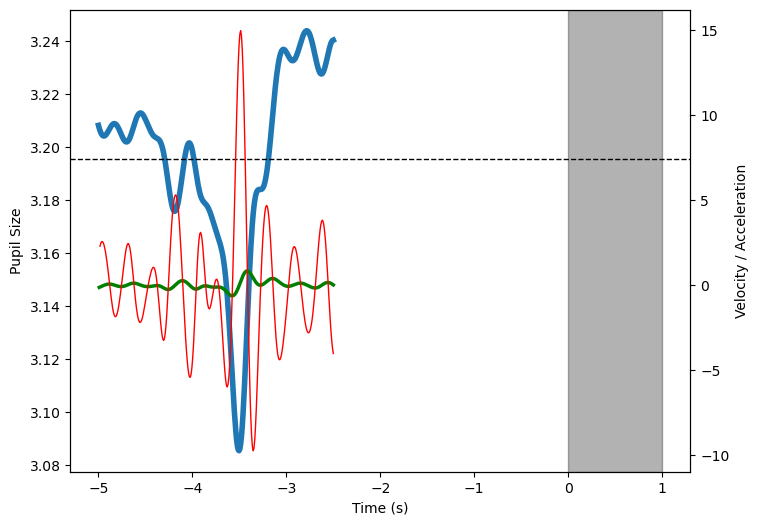

In [38]:
fig = plr.plot(vel=True, acc=True, print_params=True)
